In [86]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [3]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True)
    return x, PMT1

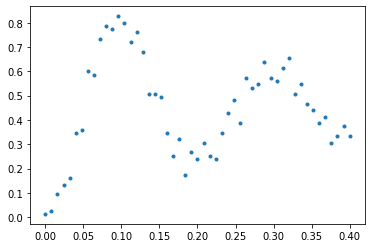

In [99]:
xB, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_004')
plt.plot(xB, BSB, '.')

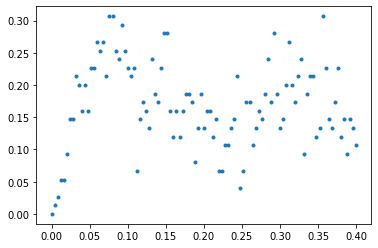

In [100]:
xR, RSB = readFile('RamanTimeScan_CounterProp_RSB_Tilt_003')
plt.plot(xR, RSB, '.')

## Define Hamiltonian

#### Need to consider phase error and of resonance error.

In [193]:
nMax = 20
def H(times, n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, phi = 0*2*np.pi):
    H_R = 1j*etaOmega/2*(np.exp(1j*phi)*qt.tensor(qt.sigmap(), qt.destroy(nMax))-np.exp(-1j*phi)*qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = 1j*etaOmega/2*(np.exp(1j*phi)*qt.tensor(qt.sigmam(), qt.destroy(nMax))-np.exp(-1j*phi)*qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

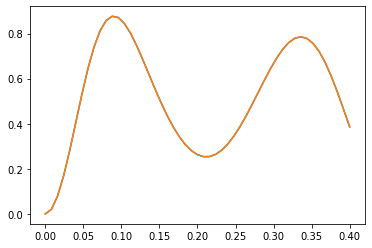

In [206]:
H1 = H(xB, 0.5, False, 0, 29, phi = 0*2*np.pi)
plt.plot(xB, H1)
H2 = H(xB, 0.5, False, 0, 29, phi = 0.9*2*np.pi)
plt.plot(xB, H2)

## Curve fit

In [194]:
def Red(times, n0, etaOmega, phi):
    return H(times, n0, True, 0, etaOmega, phi)
def Blue(times, n0, etaOmega, phi):
    return H(times, n0, False, 0, etaOmega, phi)

In [199]:
def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess, bounds=(0, [10, 100, 2*np.pi]))
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f, phi = %5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    print(popt)
    return Red(xdata, *popt)
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess, bounds=(0, [10, 100, 2*np.pi]), method = 'trf')
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f, phi = %5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    print(popt)
    return Blue(xdata, *popt)

[ 0.65564676 31.04492987  6.28318531]


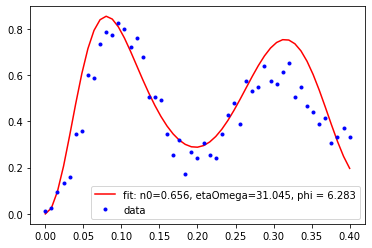

In [202]:
### BSB
xdata = xB
ydata = BSB
guess = np.array([0.3, 29, 0.3*np.pi])
BSB_fit = FitBlue(xdata, ydata, guess)

[ 0.4594563  29.78161424  6.28318531]


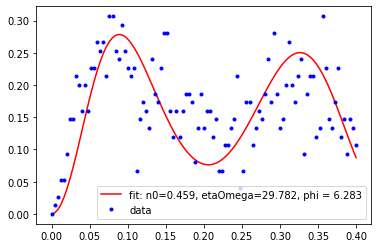

In [201]:
### RSB
xdata = xR
ydata = RSB
guess = np.array([0.2, 29, 0.1*np.pi])
RSB_fit = FitRed(xdata, ydata, guess)

NameError: name 'times' is not defined

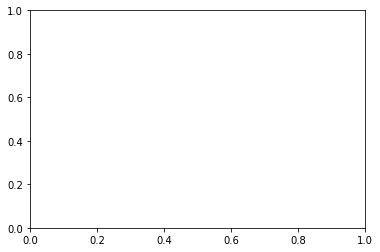

In [48]:
fig = plt.figure()
ax1 = plt.subplot(111)

plt.plot(times, RSB_fit/(BSB_fit-RSB_fit), label = "$P_R/(P_B-P_R)$")
plt.ylim(0, 15)
plt.xlabel("Time")
plt.ylabel("Avg Phonon number")
plt.legend(loc = "upper right")
plt.show()
# fig.savefig('AvgPhonon.png')

## Least square fitting

In [106]:
def LeastSquareFitting(x, ydata, fitdata):
    R = 0
    for i in range(len(x)):
        R += (ydata[i]-fitdata[i])**2
    return R

In [140]:
def ScanParameters(n0s, etaOmegas):
    R_red = np.zeros((len(n0s), len(etaOmegas))) 
    R_blue = np.zeros((len(n0s), len(etaOmegas)))  
    Gamma = 0
    for i in range(len(n0s)):
        for j in range(len(etaOmegas)):
            H_red = Red(xR[:51], n0s[i], etaOmegas[j])
            H_blue = Blue(xB[:26], n0s[i], etaOmegas[j])
            R_red[i][j] = LeastSquareFitting(xR[:51], RSB[:51], H_red)
            R_blue[i][j] = LeastSquareFitting(xB[:26], BSB[:26], H_blue)
    return R_red/len(xR[:51]), R_blue/len(xB[:26])

In [174]:
n0s = np.linspace(0.01, 1, 51)
etaOmegas = np.array([28, 29])
now1 = datetime.datetime.now()
R_red, R_blue = ScanParameters(n0s, etaOmegas)
now2 = datetime.datetime.now()
print('time elapsed:', now2-now1)

time elapsed: 0:00:03.059265


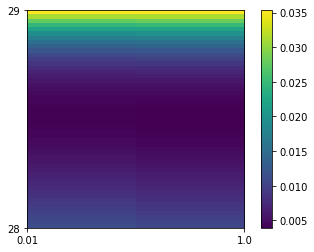

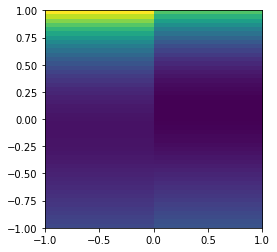

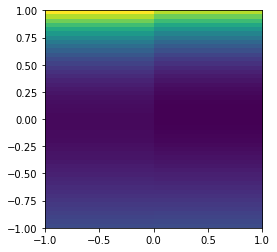

In [175]:
extent = [-1,1,-1,1]
fig, ax = plt.subplots(1,1)

img = ax.imshow(R_red,extent=[-1,1,-1,1])

x_label_list = [str(n0s[0]), str(n0s[-1])]

ax.set_xticks([-1,1])

ax.set_xticklabels(x_label_list)

y_label_list = [str(etaOmegas[0]), str(etaOmegas[-1])]

ax.set_yticks([-1,1])

ax.set_yticklabels(y_label_list)

fig.colorbar(img)


plt.imshow(R_red, extent = extent)
plt.show()
plt.imshow(R_blue, extent = extent)
plt.show()
plt.imshow(R_blue+R_red, extent = extent)
plt.show()

### Add two Rs together

In [176]:
R = R_red+R_blue

In [177]:
row, col = np.where(R == R.min())
n0 = n0s[row][0]
etaOmega = etaOmegas[col][0]
print('Min(R) = ', R.min())
print(n0)
print(etaOmega)

Min(R) =  0.010343847815217405
0.48519999999999996
29


In [178]:
row, col = np.where(R_red == R_red.min())
n0_r = n0s[row][0]
etaOmega_r = etaOmegas[col][0]
print('Min(R) = ', R_red.min())
print(n0_r)
print(etaOmega_r)

Min(R) =  0.003929679879501278
0.5049999999999999
29


In [179]:
row, col = np.where(R_blue == R_blue.min())
n0_b = n0s[row][0]
etaOmega_b = etaOmegas[col][0]
print('Min(R) = ', R_blue.min())
print(n0_b)
print(etaOmega_b)

Min(R) =  0.006385204054568425
0.4654
29


## Plot the corresponding fitting curve

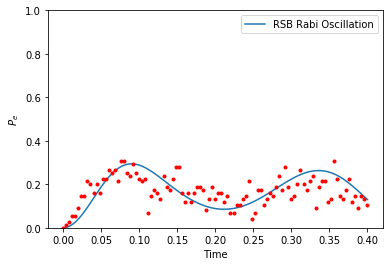

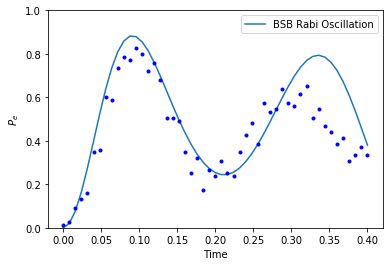

In [184]:
Gamma = 0

'''ax = plt.subplot(111)
ax.plot(xR, Red(xR, n0, etaOmegas), 'r-', label = "RSB Rabi Oscillation")
ax.plot(xB, Blue(xB, n0, etaOmegas), 'b-', label = "BSB Rabi Oscillation")
ax.plot(xR, RSB, 'r.')
ax.plot(xB, BSB, 'b.')
ax.set_xlabel("Time")
ax.set_ylabel("$P_e$")
ax.legend(loc = "upper right")
plt.show()'''



fig = plt.figure()
ax1 = plt.subplot(111)
ax1.plot(xR, Red(xR, n0_r, etaOmega_r), label = "RSB Rabi Oscillation")
ax1.plot(xR, RSB, 'r.')
ax1.set_xlabel("Time")
ax1.set_ylabel("$P_e$")
plt.ylim(0, 1)
ax1.legend(loc = "upper right")
plt.show()
ax2 = plt.subplot(111)
ax2.plot(xB, Blue(xB, n0_b, etaOmega_b), label = "BSB Rabi Oscillation")
ax2.plot(xB, BSB, 'b.')
ax2.set_xlabel("Time")
ax2.set_ylabel("$P_e$")
plt.ylim(0, 1)
ax2.legend(loc = "upper right")
plt.show()
# fig.savefig('RB_Rabi.png')

/Users/sunke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


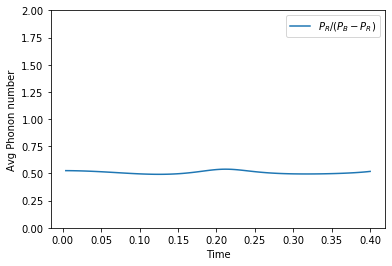

In [181]:
fig = plt.figure()
ax1 = plt.subplot(111)

times = xR
H_R = Red(times, n0_r, etaOmega_r)
H_B = Blue(times, n0_b, etaOmega_b)

# H_B = list(H_BB)
# del H_B[1::2]
# H_B = H_B[:-1]
# H_R = H_R[:len(H_R)//2]

plt.plot(times, H_R/(H_B-H_R), label = "$P_R/(P_B-P_R)$")
plt.ylim(0, 2)
plt.xlabel("Time")
plt.ylabel("Avg Phonon number")
plt.legend(loc = "upper right")
plt.show()
# fig.savefig('AvgPhonon.png')

## Fit it

In [ ]:
import os

fnames = []
for root, dirs, files in os.walk("."):
    for filename in files:
        fnames.append(filename)
print(sorted(fnames))